# Effect of Entanglement on Model Training in QML

### Importing the required libraries

In [56]:
from qiskit.ml.datasets import *
from qiskit import QuantumCircuit
from qiskit.aqua.components.optimizers import COBYLA, AQGD, ADAM
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, DensityMatrix, entropy
from qiskit import execute
%matplotlib inline

### Loading the Ad Hoc dataset from `qiskit.ml.datasets`

In [57]:
training_size = 100
# size of test data set
test_size = 20
# dimension of data sets
n = 2
# construct training and test data
_, training_input, test_input, class_labels = \
ad_hoc_data(training_size=training_size, test_size=test_size, n=n, gap=0.3, plot_data=False)
print(class_labels)

['A', 'B']


### Preparing the Variational Quantum Classifier Circuit

Use of the `ZZFeatureMap` as the Quantum Feature Map and `Real Amplitudes` as Variational circuit from `qiskit.circuit.library`

In [58]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.draw()

┌───┐┌─────────────┐                                          ┌──────────┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ RY(θ[0]) ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐├──────────┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ RY(θ[1]) ├»
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘└──────────┘»
«          ┌──────────┐
«q_0: ──■──┤ RY(θ[2]) ├
«     ┌─┴─┐├──────────┤
«q_1: ┤ X ├┤ RY(θ[3]) ├
«     └───┘└──────────┘

In [59]:
# Preparing the parameter dictionary

def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = params[i]
    return parameters


### Getting a Glimpse of the circuit with initialized parameters

In [60]:
data = [0.1, 1.2]
params = np.array([0.1, 1.2, 0.02, 0.1])
circ_ = circuit.assign_parameters(get_data_dict(params, data))
circ_.draw(plot_barriers=True)

┌───┐┌──────────────────────┐                                 »
q_0: ┤ H ├┤ P(0.200000000000000) ├──■───────────────────────────■──»
     ├───┤├─────────────────────┬┘┌─┴─┐┌─────────────────────┐┌─┴─┐»
q_1: ┤ H ├┤ P(2.40000000000000) ├─┤ X ├┤ P(11.8110679028453) ├┤ X ├»
     └───┘└─────────────────────┘ └───┘└─────────────────────┘└───┘»
«     ┌───────────────────────┐     ┌────────────────────────┐
«q_0: ┤ RY(0.100000000000000) ├──■──┤ RY(0.0200000000000000) ├
«     └┬──────────────────────┤┌─┴─┐├───────────────────────┬┘
«q_1: ─┤ RY(1.20000000000000) ├┤ X ├┤ RY(0.100000000000000) ├─
«      └──────────────────────┘└───┘└───────────────────────┘

### Setting up the environment for Quantum Classification

In [61]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

In [62]:
def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
        class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

In [63]:
return_probabilities({'00' : 10, '01': 10, '11': 20}, class_labels)

{'A': 0.75, 'B': 0.25}

In [11]:
def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ_)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.to_counts()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


In [12]:
x = np.asarray([[0.5, 0.9]])
classify(x, params=np.array([0.8, -0.5, 1.5, 0,5]), class_labels=class_labels)

[{'A': 0.9058187060399014, 'B': 0.09418129396009857}]

### Defining the Cost function estimate

In [13]:
def cost_estimate_sigmoid(probs, expected_label): # probability of labels vs actual labels
    p = probs.get(expected_label)
    sig = None
    if np.isclose(p, 0.0):
        sig = 1
    elif np.isclose(p, 1.0):
        sig = 0
    else:
        denominator = np.sqrt(2*p*(1-p))
        x = np.sqrt(200)*(0.5-p)/denominator
        sig = 1/(1+np.exp(-x))
    return sig

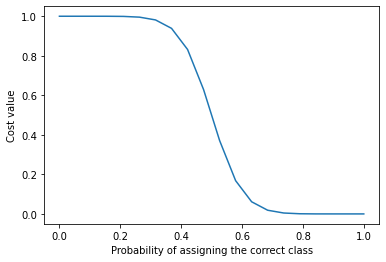

In [14]:
x = np.linspace(0, 1, 20)
y = [cost_estimate_sigmoid({'A': x_, 'B': 1-x_}, 'A') for x_ in x]
plt.plot(x, y)
plt.xlabel('Probability of assigning the correct class')
plt.ylabel('Cost value')
plt.show()


### Creating the cost function

In [111]:
loss_function_values = []
def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]
    # classify all samples
    probs = classify(training_samples, params, class_labels)
    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += cost_estimate_sigmoid(prob, training_labels[i])
    cost /= len(training_samples)
    # print resulting objective function
    if print_value:
        loss_function_values.append(cost)
        print('%.4f' % cost)
    # return objective value
    return cost


In [112]:
cost_function(training_input, class_labels, params)

0.2541554066388654

### Optimizer Setup

We use the ADAM optimizer and save the parameter after every step in a file named `adam_params.csv` by specifying the `snapshot_dir` argument.

In [114]:
loss_function_values = []
optimizer = ADAM(maxiter=50, snapshot_dir=r'C:\Users\farha\Desktop\Quantum\github-farhan\QOSFProgram')
# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)
# randomly initialize the parameters
np.random.seed(137)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value) 

0.6350
0.6350
0.6350
0.6350
0.6350
0.6349
0.6349
0.6349
0.6349
0.6349
0.6347
0.6347
0.6347
0.6347
0.6347
0.6346
0.6346
0.6346
0.6346
0.6346
0.6344
0.6344
0.6344
0.6344
0.6344
0.6343
0.6343
0.6343
0.6343
0.6343
0.6341
0.6341
0.6341
0.6341
0.6341
0.6340
0.6340
0.6340
0.6340
0.6340
0.6338
0.6338
0.6338
0.6338
0.6338
0.6337
0.6337
0.6337
0.6337
0.6337
0.6335
0.6335
0.6335
0.6335
0.6335
0.6334
0.6334
0.6334
0.6334
0.6334
0.6332
0.6332
0.6332
0.6332
0.6332
0.6331
0.6331
0.6331
0.6331
0.6331
0.6329
0.6329
0.6329
0.6329
0.6329
0.6328
0.6328
0.6328
0.6328
0.6328
0.6326
0.6326
0.6326
0.6326
0.6326
0.6325
0.6325
0.6325
0.6325
0.6325
0.6323
0.6323
0.6323
0.6323
0.6323
0.6322
0.6322
0.6322
0.6322
0.6322
0.6320
0.6320
0.6320
0.6320
0.6320
0.6319
0.6319
0.6319
0.6319
0.6319
0.6317
0.6317
0.6317
0.6317
0.6317
0.6316
0.6316
0.6316
0.6316
0.6316
0.6314
0.6314
0.6314
0.6314
0.6314
0.6313
0.6313
0.6313
0.6313
0.6313
0.6311
0.6311
0.6311
0.6311
0.6311
0.6309
0.6309
0.6309
0.6309
0.6309
0.6308
0.6308
0.6308

## Measuring Entropies as the QML model trains

In [41]:

vn_entropy = []
epochs = []
epoch_var = 0

import pandas as pd 

# Loading the data from adam_params.csv
df = pd.read_csv(r'C:\Users\farha\Desktop\Quantum\github-farhan\QOSFProgram\adam_params.csv', usecols = ['m'])

arr = df.to_numpy()
param_array = []
for i in arr:
    a_list =i[0].rstrip(']').lstrip('[').split()
    map_object = map(float, a_list)
    list_of_integers = list(map_object)
    param_array.append(list_of_integers)


In [46]:
print(len(param_array))
print(param_array[0])

48
[-0.00730427, -0.00114775, -0.00303513, 0.00280176]


### Calculating vonNeumann entropy as the circuit trains

Entropy is measured by calculating the Density Matrix of the state after every iteration and passing it to the `entropy` function from `qiskit.quantum_info` library. 

In [67]:
vn_entropy = []
epochs = [x for x in range(len(param_array))]
for i in range(len(param_array)):
    x_list = np.asarray([[0.5, 0.9]])
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(np.array(param_array[i]), x))
        qc = sv.evolve(circ_)
        print(circ_)

    ckt_state = execute(circ_, backend = Aer.get_backend('statevector_simulator'), shots = 500).result().get_statevector()
    D = DensityMatrix(ckt_state)
    vn_entropy_val = entropy(D, base=2)
    vn_entropy.append(vn_entropy_val)


├──■───────────────────────────■──»
     ├───┤├─────────────────────┤┌─┴─┐┌─────────────────────┐┌─┴─┐»
q_1: ┤ H ├┤ P(1.80000000000000) ├┤ X ├┤ P(11.8427493721273) ├┤ X ├»
     └───┘└─────────────────────┘└───┘└─────────────────────┘└───┘»
«     ┌─────────────────────────┐     ┌─────────────────────────┐
«q_0: ┤ RY(-0.0606944600000000) ├──■──┤ RY(-0.0213285100000000) ├
«     ├─────────────────────────┤┌─┴─┐└┬────────────────────────┤
«q_1: ┤ RY(-0.0103910400000000) ├┤ X ├─┤ RY(0.0217171000000000) ├
«     └─────────────────────────┘└───┘ └────────────────────────┘
     ┌───┐┌─────────────────────┐                                 »
q_0: ┤ H ├┤ P(1.00000000000000) ├──■───────────────────────────■──»
     ├───┤├─────────────────────┤┌─┴─┐┌─────────────────────┐┌─┴─┐»
q_1: ┤ H ├┤ P(1.80000000000000) ├┤ X ├┤ P(11.8427493721273) ├┤ X ├»
     └───┘└─────────────────────┘└───┘└─────────────────────┘└───┘»
«     ┌─────────────────────────┐     ┌─────────────────────────┐
«q_0: ┤ RY(-0.0614784200

### Calculating Meyer-Wallach entropy as the circuit trains

Meyer Wallach entropy is calculated using the `qutip` library and the implementation is available at `compute_Q_ptrace(ket, N)` function of `meyer_wallach_entanglement.py`.

In [105]:
from libraries.meyer_wallach_measure import compute_Q_ptrace
mw_entropy = []
epochs = [x for x in range(len(param_array))]
for i in range(len(param_array)):
    x_list = np.asarray([[0.5, 0.9]])
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(np.array(param_array[i]), x))
        qc = sv.evolve(circ_)
        print(qc)
        k = np.array(list(qc.to_dict().values()))
  
    
    
    mw_val = compute_Q_ptrace(k, 2)
    print(mw_val)
    mw_entropy.append(mw_val)
    

.08496443+0.09360423j]
 [-0.08496443-0.09360423j  0.25509081+0.j        ]]
0.9355921919449846
Statevector([ 0.50872149+0.00347446j, -0.49148266+0.15106349j,
              0.22973352+0.44667888j,  0.45441453+0.13424947j],
            dims=(2, 2))
KET=   Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.50872149+0.00347446j]
 [-0.49148266+0.15106349j]
 [ 0.22973352+0.44667888j]
 [ 0.45441453+0.13424947j]]
value of n 0 PTrace:  Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.28931464+0.j         -0.08463433-0.09181021j]
 [-0.08463433+0.09181021j  0.24294462+0.j        ]]
value of n 1 PTrace:  Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.27723876+0.j         -0.08514228+0.09357889j]
 [-0.08514228-0.09357889j  0.2550205 +0.j        ]]
0.9354814846638457
Statevector([ 0.508867  +0.00351076j, -0.49150809+0.15097079j,
              0.2295707 +0.44669478j,  0.45430

----------------------------------------------------
Data point:  [6.03185789 1.75929189]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.6371296776445223, 'B': 0.36287032235547767}
Classification: CORRECT
----------------------------------------------------
Data point:  [2.76460154 4.1469023 ]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7245564219880569, 'B': 0.2754435780119432}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.52920307 0.12566371]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.5167446580353187, 'B': 0.48325534196468134}
Classification: CORRECT
----------------------------------------------------
Data point:  [2.76460154 4.33539786]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.725650478670102, 'B': 0.274349521329898}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.90619419 1.82212374]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.6586879715483345, 'B': 0.34131202845166564}
Cla

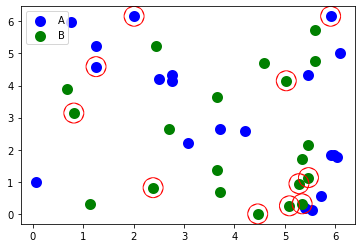

In [20]:
# collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]
# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []

# evaluate test data
for label, samples in test_input.items():
    # classify samples
    results = classify(samples, opt_params, class_labels)
    # analyze results
    for i, result in enumerate(results):
        # assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point: ', samples[i])
        print('Label: ', label)
        print('Assigned: ', assigned_label)
        print('Probabilities: ', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")
# plot results
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, facecolors='none',
edgecolors='r')
plt.legend()
plt.show()

## Plotting the results obtained

### Number of epochs vs the loss function

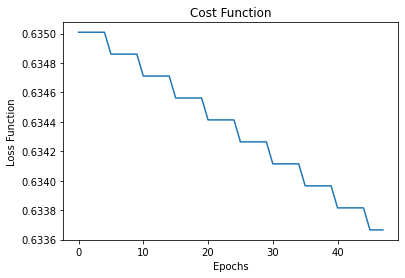

In [142]:
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.title('Cost Function')
plt.plot(epochs, loss_function_values[0:48], color='tab:blue')
plt.show()

### Number of epochs vs the von-Neumann entropy measure

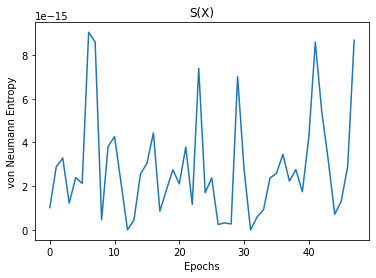

In [69]:
plt.xlabel('Epochs')
plt.ylabel('von Neumann Entropy')
plt.title('S(X)')
plt.plot(epochs, vn_entropy, color='tab:blue')
plt.show()

### Number of epochs vs the Meyer Wallach entropy measure

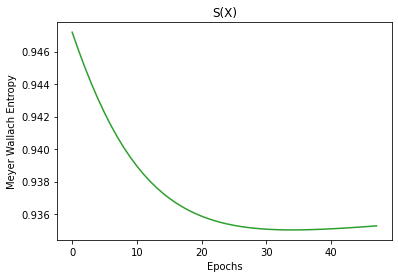

In [107]:
plt.xlabel('Epochs')
plt.ylabel('Meyer Wallach Entropy')
plt.title('S(X)')
plt.plot(epochs, mw_entropy, color='tab:green')
plt.show()

### Loss Function vs the von-Neumann entropy measure

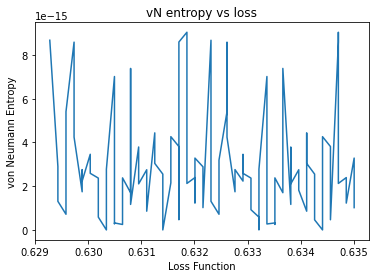

In [135]:
plt.xlabel('Loss Function')
plt.ylabel('von Neumann Entropy')
plt.title('vN entropy vs loss')
plt.plot( loss_function_values[0:191:2], vn_entropy, color='tab:blue')
plt.show()

### Loss function vs the Meyer-Wallach entropy measure

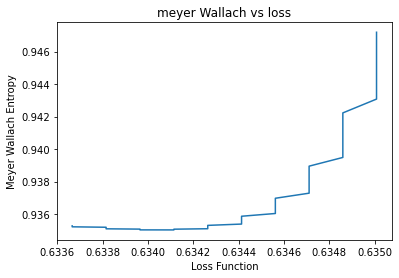

In [121]:
plt.xlabel('Loss Function')
plt.ylabel('Meyer Wallach Entropy')
plt.title('meyer Wallach vs loss')
plt.plot( loss_function_values[0:48], mw_entropy, color='tab:blue')
plt.show()